In [192]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [193]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
#     print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [194]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/data.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [195]:
data_copy = king_all_copy
data_copy['date']
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [196]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [197]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [198]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [89]:
# type(data_copy['date'])
# # data_copy['date'].astype(p)

<h2>Load PDO data and Concatenate with Salmon Data to make Master Dataset</h2>

In [199]:
def load_pdo(pathname):
    pdo_data = pd.read_csv(pathname)
    return pdo_data

In [200]:
ismael_path_pdo = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/pdo.csv'
pdo_data = load_pdo(ismael_path_pdo)
pdo_data

,Date,Month,PDO
0,1939,1,1.17
1,1939,2,-0.10
2,1939,3,-0.63
3,1939,4,0.03
4,1939,5,0.12
...,...,...,...
983,2020,12,-0.98
984,2021,1,-0.61
985,2021,2,-1.09
986,2021,3,-1.65


In [201]:
master_data = data_copy

In [202]:
pdo = pdo_data["PDO"]
pdo = pdo[:984]
pdo
master_data = master_data.join(pdo)
# master_data
# master_data = master_data[:984]
# master_data = master_data.reindex(columns=["Date", "Month", "king", "PDO"])
# master_data

In [203]:
# master_data.columns = ['year', 'month', 'king', 'pdo']
master_data

,date,king,PDO
0,1939-01-31,6,1.17
1,1939-02-28,12,-0.10
2,1939-03-31,121,-0.63
3,1939-04-30,51410,0.03
4,1939-05-31,25159,0.12
...,...,...,...
979,2020-08-31,105269,-1.32
980,2020-09-30,254930,-1.03
981,2020-10-31,30917,-0.62
982,2020-11-30,843,-1.58


In [204]:
master_data

,date,king,PDO
0,1939-01-31,6,1.17
1,1939-02-28,12,-0.10
2,1939-03-31,121,-0.63
3,1939-04-30,51410,0.03
4,1939-05-31,25159,0.12
...,...,...,...
979,2020-08-31,105269,-1.32
980,2020-09-30,254930,-1.03
981,2020-10-31,30917,-0.62
982,2020-11-30,843,-1.58


In [205]:
# master_data['year']=pd.to_datetime(master_data[['year','month']])
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,PDO
date,,
1939-01-31,6,1.17
1939-02-28,12,-0.10
1939-03-31,121,-0.63
1939-04-30,51410,0.03
1939-05-31,25159,0.12
...,...,...
2020-08-31,105269,-1.32
2020-09-30,254930,-1.03
2020-10-31,30917,-0.62


In [206]:
master_data.to_csv('master_data.csv')

<h2>Let's plot each series</h2>

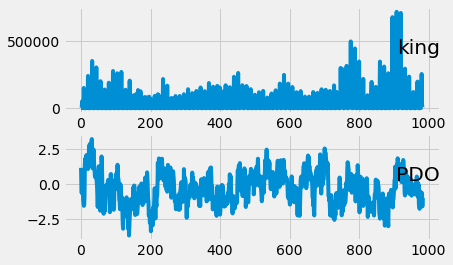

In [218]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [270]:
# convert series to supervised learning
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 2
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var1(t-5)  var2(t-5)  var1(t-4)  var2(t-4)  \
6    0.000014   0.826829   0.000022   0.551220   0.000174   0.426829   
7    0.000022   0.551220   0.000174   0.426829   0.071615   0.582927   
8    0.000174   0.426829   0.071615   0.582927   0.035050   0.604878   
9    0.071615   0.582927   0.035050   0.604878   0.007850   0.558537   
10   0.035050   0.604878   0.007850   0.558537   0.024862   0.319512   

    var1(t-3)  var2(t-3)  var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)  \
6    0.071615   0.582927   0.035050   0.604878   0.007850   0.558537   
7    0.035050   0.604878   0.007850   0.558537   0.024862   0.319512   
8    0.007850   0.558537   0.024862   0.319512   0.045734   0.273171   
9    0.024862   0.319512   0.045734   0.273171   0.210128   0.221951   
10   0.045734   0.273171   0.210128   0.221951   0.003066   0.234146   

     var1(t)   var2(t)  
6   0.024862  0.319512  
7   0.045734  0.273171  
8   0.210128  0.221951  
9   0.003066  0.234146  
10  0.000

In [271]:
# split into train and test sets
values = reframed.values
n_train_months = 77 * 12
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(924, 6, 2) (924,) (54, 6, 2) (54,)


In [278]:
# train_X
train_y

array([2.48621348e-02, 4.57335711e-02, 2.10128158e-01, 3.06580542e-03,
       1.14219009e-04, 2.78582957e-05, 5.57165913e-06, 5.57165913e-06,
       7.07600673e-04, 5.18958271e-02, 3.98721881e-02, 9.79497749e-03,
       2.08129324e-02, 8.16902742e-02, 3.35001588e-01, 5.24989562e-03,
       4.05338214e-04, 5.29307617e-05, 1.11433183e-05, 5.57165913e-06,
       1.89993577e-03, 7.17211813e-02, 2.70907991e-02, 9.77408327e-03,
       1.30920066e-02, 1.75423678e-02, 4.90265608e-01, 1.00053074e-02,
       1.21183589e-03, 1.97793910e-04, 6.96457391e-06, 2.64653809e-05,
       5.29307617e-05, 1.32466201e-02, 4.30675335e-02, 1.64642520e-02,
       1.78641323e-02, 3.84235568e-02, 4.23444688e-01, 6.25279453e-03,
       8.95644189e-04, 2.70225486e-04, 2.08937217e-05, 1.39291478e-05,
       6.54669930e-05, 1.69601291e-02, 7.42033571e-02, 7.58302817e-03,
       1.12101790e-02, 4.03792076e-02, 2.80553937e-01, 4.67740791e-03,
       5.13985520e-04, 3.48228714e-05, 6.96457391e-06, 8.35748870e-06,
      

Epoch 1/200
10/10 - 1s - loss: 0.0526 - val_loss: 0.0551
Epoch 2/200
10/10 - 0s - loss: 0.0498 - val_loss: 0.0561
Epoch 3/200
10/10 - 0s - loss: 0.0489 - val_loss: 0.0544
Epoch 4/200
10/10 - 0s - loss: 0.0469 - val_loss: 0.0532
Epoch 5/200
10/10 - 0s - loss: 0.0487 - val_loss: 0.0530
Epoch 6/200
10/10 - 0s - loss: 0.0461 - val_loss: 0.0522
Epoch 7/200
10/10 - 0s - loss: 0.0471 - val_loss: 0.0519
Epoch 8/200
10/10 - 0s - loss: 0.0461 - val_loss: 0.0514
Epoch 9/200
10/10 - 0s - loss: 0.0466 - val_loss: 0.0512
Epoch 10/200
10/10 - 0s - loss: 0.0457 - val_loss: 0.0507
Epoch 11/200
10/10 - 0s - loss: 0.0463 - val_loss: 0.0506
Epoch 12/200
10/10 - 0s - loss: 0.0453 - val_loss: 0.0501
Epoch 13/200
10/10 - 0s - loss: 0.0463 - val_loss: 0.0499
Epoch 14/200
10/10 - 0s - loss: 0.0451 - val_loss: 0.0495
Epoch 15/200
10/10 - 0s - loss: 0.0459 - val_loss: 0.0493
Epoch 16/200
10/10 - 0s - loss: 0.0451 - val_loss: 0.0491
Epoch 17/200
10/10 - 0s - loss: 0.0454 - val_loss: 0.0489
Epoch 18/200
10/10 - 0s

Epoch 142/200
10/10 - 0s - loss: 0.0406 - val_loss: 0.0467
Epoch 143/200
10/10 - 0s - loss: 0.0394 - val_loss: 0.0416
Epoch 144/200
10/10 - 0s - loss: 0.0404 - val_loss: 0.0438
Epoch 145/200
10/10 - 0s - loss: 0.0404 - val_loss: 0.0451
Epoch 146/200
10/10 - 0s - loss: 0.0392 - val_loss: 0.0413
Epoch 147/200
10/10 - 0s - loss: 0.0405 - val_loss: 0.0446
Epoch 148/200
10/10 - 0s - loss: 0.0404 - val_loss: 0.0440
Epoch 149/200
10/10 - 0s - loss: 0.0395 - val_loss: 0.0414
Epoch 150/200
10/10 - 0s - loss: 0.0405 - val_loss: 0.0463
Epoch 151/200
10/10 - 0s - loss: 0.0397 - val_loss: 0.0427
Epoch 152/200
10/10 - 0s - loss: 0.0399 - val_loss: 0.0423
Epoch 153/200
10/10 - 0s - loss: 0.0405 - val_loss: 0.0462
Epoch 154/200
10/10 - 0s - loss: 0.0393 - val_loss: 0.0414
Epoch 155/200
10/10 - 0s - loss: 0.0402 - val_loss: 0.0438
Epoch 156/200
10/10 - 0s - loss: 0.0402 - val_loss: 0.0449
Epoch 157/200
10/10 - 0s - loss: 0.0391 - val_loss: 0.0412
Epoch 158/200
10/10 - 0s - loss: 0.0402 - val_loss: 0.04

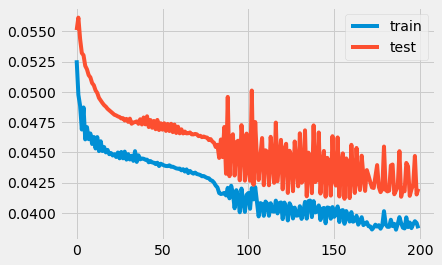

In [273]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [274]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))

In [275]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [276]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 68278.586


In [85]:
# def create_train_test(king_all):
#     king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
#     king_training = king_all[king_training_parse]
#     king_training = king_training.reset_index()
#     king_training = king_training.drop('index', axis=1)
    
#     king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
#     king_test = king_all[king_test_parse]
#     king_test = king_test.reset_index()
#     king_test = king_test.drop('index', axis=1)
#     print(king_test.shape)
    
#     # Normalizing Data
#     king_training[king_training["king"] < 0] = 0 
# #     print('max val king_train:')
#     print(max(king_training['king']))
#     king_test[king_test["king"] < 0] = 0
# #     print('max val king_test:')
#     print(max(king_test['king']))
#     king_train_pre = king_training["king"].to_frame()
# #     print(king_train_norm)
#     king_test_pre = king_test["king"].to_frame()
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     king_train_norm = scaler.fit_transform(king_train_pre)
#     king_test_norm = scaler.fit_transform(king_test_pre)
#     print('king_test_norm')
#     print(king_test_norm.shape)
#     print('king_train_norm')
#     print(king_train_norm.shape)
#     #king_train_norm = (king_training["king"] - np.min(king_training["king"])) / (np.max(king_training["king"]) - np.min(king_training["king"]))
#     #print(type(king_train_norm))
#     #king_train_norm = king_train_norm.to_frame()
#     x_train = []
#     y_train = []
#     x_test = []
#     y_test = []
#     y_test_not_norm = []
#     y_train_not_norm = []
    
#     # Todo: Experiment with input size of input (ex. 30 days)
    
#     for i in range(6,924): # 30
#         x_train.append(king_train_norm[i-6:i])
#         y_train.append(king_train_norm[i])
#     for i in range(6, 60):
#         x_test.append(king_test_norm[i-6:i])
#         y_test.append(king_test_norm[i])
    
#     # make y_test_not_norm
#     for i in range(6, 60):
#         y_test_not_norm.append(king_test['king'][i])
#     for i in range(6,924): # 30
#         y_train_not_norm.append(king_training['king'][i])
        
#     return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [86]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
print(y_test.shape)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
print(y_test_not_norm.shape)
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))
print(y_train_not_norm.shape)
print(y_train.shape)


(60, 2)
717915
294611
king_test_norm
(60, 1)
king_train_norm
(924, 1)
(54, 1)
(54, 1)
(918, 1)
(918, 1)


In [176]:
# def load_pdo(pathname):
#     pdo_data = pd.read_csv(pathname)
# #     print(pdo_data.head())
#     return pdo_data

In [177]:
# ismael_path_pdo = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/pdo.csv'
# pdo_data = load_pdo(ismael_path_pdo)

In [178]:
# pdo = pdo_data["PDO"]
# data_copy = data_copy.join(pdo)

In [179]:
# pdo_data

In [180]:
# print(data_copy)